In [24]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFoldFold
sys.path.append('/root/code/elo/Tools/')
from plot import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_df = pd.read_csv('/root/tempfile/train_final122002.csv')
test_df = pd.read_csv('/root/tempfile/test_final122002.csv')

In [3]:
print(train_df.shape, test_df.shape)

(201917, 265) (123623, 264)


In [4]:
feature_col = [x for x in train_df.columns if x not in ['card_id','target']]
y_train = train_df.target.values.astype('float')
x_train = train_df[feature_col].values.astype('float')
x_test = test_df[feature_col].values.astype('float')

In [5]:
testindex = test_df.card_id

In [6]:
del train_df, test_df

In [7]:
lgb_model = lgb.LGBMRegressor(objective='regression',
                              min_data_in_leaf=20,
                              num_leaves=50,
                              learning_rate=0.1, 
                              n_estimators=43, 
                              max_depth=8,
                              metric='mse',
                              bagging_fraction = 0.8,
                              feature_fraction = 0.8)

In [ ]:
params_test1={
    'max_depth': range(8,11,1),
    'num_leaves':range(100, 300, 20),
    'min_data_in_leaf':range(100,300,20)
}
gsearch1 = GridSearchCV(estimator=lgb_model, 
                        param_grid=params_test1,
                        scoring='neg_mean_squared_error', 
                        cv=5,
                        verbose=1, 
                        n_jobs=8)

gs1 = gsearch1.fit(x_train, y_train)

In [ ]:
print(gs1.best_params_, gs1.best_score_)

In [ ]:
alpha = np.array(range(100, 300, 20))
beta = np.array(range(100,300,20))
score = np.array(gs1.cv_results_['mean_test_score'][:100])

plot3D(alpha, beta, score, elev=30, azim=90)

In [10]:
params_test2={
    'max_depth': [8],
    'num_leaves':range(100, 170, 10),
    'min_data_in_leaf':range(200,260,10)
}
gsearch2 = GridSearchCV(estimator=lgb_model, 
                        param_grid=params_test2,
                        scoring='neg_mean_squared_error', 
                        cv=5,
                        verbose=1, 
                        n_jobs=8)

gs2 = gsearch2.fit(x_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 14.4min
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed: 16.5min finished


In [11]:
print(gs2.best_params_, gs2.best_score_)

{'max_depth': 8, 'min_data_in_leaf': 240, 'num_leaves': 140} -13.408972438756566


(6, 7) (6, 7) (6, 7)


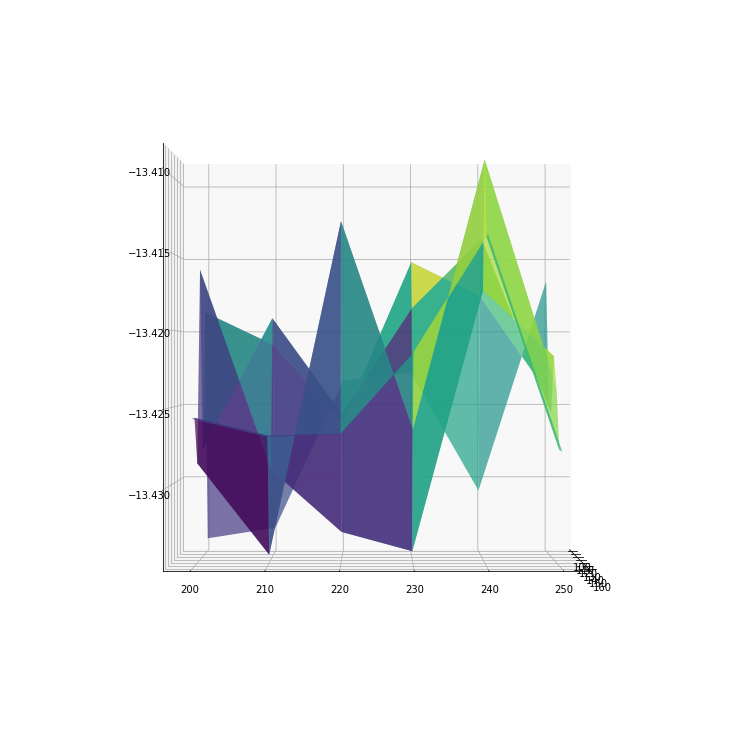

In [19]:
alpha = np.array(range(100, 170, 10))
beta = np.array(range(200,260,10))
score = np.array(gs2.cv_results_['mean_test_score'])

plot3D(alpha, beta, score, elev=0, azim=0, figsize=[10,10])

In [20]:
params_test2={
    'max_depth': [8],
    'num_leaves':range(130, 150, 2),
    'min_data_in_leaf':range(230,250,2)
}
gsearch2 = GridSearchCV(estimator=lgb_model, 
                        param_grid=params_test2,
                        scoring='neg_mean_squared_error', 
                        cv=5,
                        verbose=1, 
                        n_jobs=8)

gs2 = gsearch2.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 14.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 33.8min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 38.7min finished


In [21]:
print(gs2.best_params_, gs2.best_score_)

{'max_depth': 8, 'min_data_in_leaf': 240, 'num_leaves': 140} -13.408972438756566


(10, 10) (10, 10) (10, 10)


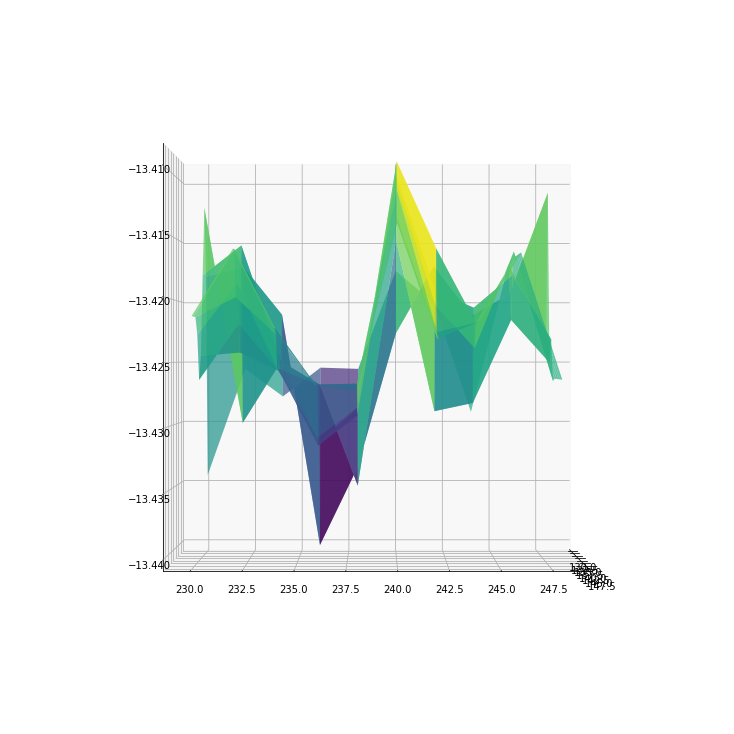

In [22]:
alpha = np.array(range(130, 150, 2))
beta = np.array(range(230,250, 2))
score = np.array(gs2.cv_results_['mean_test_score'])

plot3D(alpha, beta, score, elev=0, azim=0, figsize=[10,10])

In [23]:
params_test2={
    'max_depth': [8],
    'num_leaves':[139, 140, 141],
    'min_data_in_leaf':[239, 240, 241]
}
gsearch2 = GridSearchCV(estimator=lgb_model, 
                        param_grid=params_test2,
                        scoring='neg_mean_squared_error', 
                        cv=5,
                        verbose=1, 
                        n_jobs=8)

gs2 = gsearch2.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:  3.8min finished


In [24]:
print(gs2.best_params_, gs2.best_score_)

{'max_depth': 8, 'min_data_in_leaf': 241, 'num_leaves': 141} -13.407067247568651


In [8]:
params_test3={
    'max_depth': [8],
    'num_leaves':[141],
    'min_data_in_leaf':[241],   
    "feature_fraction": np.arange(0.5,1,0.05),
    "bagging_fraction": np.arange(0.5,1,0.05)
}
gsearch3 = GridSearchCV(estimator=lgb_model, 
                        param_grid=params_test3,
                        scoring='neg_mean_squared_error', 
                        cv=5,
                        verbose=1, 
                        n_jobs=8)

gs3 = gsearch3.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 13.4min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 31.5min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 36.2min finished


In [15]:
print(gs3.best_params_, gs3.best_score_)

{'bagging_fraction': 0.5, 'feature_fraction': 0.8000000000000003, 'max_depth': 8, 'min_data_in_leaf': 241, 'num_leaves': 141} -13.407067247568651


In [17]:
params_test3={
    'max_depth': [8],
    'num_leaves':[141],
    'min_data_in_leaf':[241],   
    "feature_fraction": np.arange(0.75,0.85,0.005),
}
gsearch3 = GridSearchCV(estimator=lgb_model, 
                        param_grid=params_test3,
                        scoring='neg_mean_squared_error', 
                        cv=5,
                        verbose=1, 
                        n_jobs=8)

gs3 = gsearch3.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  8.1min finished


In [18]:
print(gs3.best_params_, gs3.best_score_)

{'feature_fraction': 0.8, 'max_depth': 8, 'min_data_in_leaf': 241, 'num_leaves': 141} -13.407067247568651


In [19]:
params_test4={
    'max_depth': [8],
    'num_leaves':[141],
    'min_data_in_leaf':[241],   
    "feature_fraction": [0.8],
    'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],   
    'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5]
}
gsearch4 = GridSearchCV(estimator=lgb_model, 
                        param_grid=params_test4,
                        scoring='neg_mean_squared_error', 
                        cv=5,
                        verbose=1, 
                        n_jobs=8)

gs4 = gsearch4.fit(x_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 14.6min
[Parallel(n_jobs=8)]: Done 245 out of 245 | elapsed: 19.2min finished


In [20]:
print(gs4.best_params_, gs4.best_score_)

{'feature_fraction': 0.8, 'max_depth': 8, 'min_data_in_leaf': 241, 'num_leaves': 141, 'reg_alpha': 0.01, 'reg_lambda': 0.01} -13.401134213902568


In [22]:
params_test4={
    'max_depth': [8],
    'num_leaves':[141],
    'min_data_in_leaf':[241],   
    "feature_fraction": [0.8],
    'reg_alpha': [0,0.005, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.015, 0.2],   
    'reg_lambda': [0,0.005, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.015, 0.2]
}
gsearch4 = GridSearchCV(estimator=lgb_model, 
                        param_grid=params_test4,
                        scoring='neg_mean_squared_error', 
                        cv=5,
                        verbose=1, 
                        n_jobs=8)
gs4 = gsearch4.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 14.7min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 33.9min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 38.8min finished


In [23]:
print(gs4.best_params_, gs4.best_score_)

{'feature_fraction': 0.8, 'max_depth': 8, 'min_data_in_leaf': 241, 'num_leaves': 141, 'reg_alpha': 0.009, 'reg_lambda': 0.005} -13.401133894487558


In [25]:
param={
    'max_depth': 8,
    'num_leaves': 141,
    'min_data_in_leaf':241,
    'reg_alpha': 0.009,   
    'reg_lambda': 0.005,
    'learning_rate':0.001,
    'bagging_fraction' : 0.8,
    'feature_fraction' : 0.8,
    'objective':'regression',
    'metric':'mse'
}

y_predict = np.zeros(x_test.shape[0])
Kfold = KFold(n_splits=5, shuffle=True, random_state=233)

for trainidx, testidx in Kfold.split(x_train, y_train):
    data_train = lgb.Dataset(x_train[trainidx], y_train[trainidx], silent=True)
    data_test = lgb.Dataset(x_train[testidx], y_train[testidx], silent=True)
    
    lgb_model = lgb.train(
        param,
        data_train,
        valid_sets=[data_test, data_train],
        num_boost_round=20000, 
        early_stopping_rounds=500,
        verbose_eval=200
    )
    y_predict = np.array(lgb_model.predict(x_test)) + y_predict
    
y_predict = y_predict / 5

Training until validation scores don't improve for 500 rounds.
[200]	training's l2: 14.3707	valid_0's l2: 14.3824
[400]	training's l2: 14.0315	valid_0's l2: 14.0845
[600]	training's l2: 13.7739	valid_0's l2: 13.8814
[800]	training's l2: 13.5729	valid_0's l2: 13.7293
[1000]	training's l2: 13.4129	valid_0's l2: 13.6221
[1200]	training's l2: 13.2825	valid_0's l2: 13.5453
[1400]	training's l2: 13.1725	valid_0's l2: 13.4841
[1600]	training's l2: 13.0803	valid_0's l2: 13.4322
[1800]	training's l2: 13.0002	valid_0's l2: 13.3912
[2000]	training's l2: 12.9263	valid_0's l2: 13.3577
[2200]	training's l2: 12.8627	valid_0's l2: 13.333
[2400]	training's l2: 12.8065	valid_0's l2: 13.3148
[2600]	training's l2: 12.7533	valid_0's l2: 13.2991
[2800]	training's l2: 12.7065	valid_0's l2: 13.2862
[3000]	training's l2: 12.6636	valid_0's l2: 13.2755
[3200]	training's l2: 12.6233	valid_0's l2: 13.2665
[3400]	training's l2: 12.5849	valid_0's l2: 13.2582
[3600]	training's l2: 12.5487	valid_0's l2: 13.2501
[3800]

[4600]	training's l2: 12.5513	valid_0's l2: 12.548
[4800]	training's l2: 12.5247	valid_0's l2: 12.5465
[5000]	training's l2: 12.4977	valid_0's l2: 12.5452
[5200]	training's l2: 12.4715	valid_0's l2: 12.5439
[5400]	training's l2: 12.4443	valid_0's l2: 12.543
[5600]	training's l2: 12.4195	valid_0's l2: 12.5429
[5800]	training's l2: 12.3944	valid_0's l2: 12.5426
[6000]	training's l2: 12.37	valid_0's l2: 12.5425
[6200]	training's l2: 12.3478	valid_0's l2: 12.5422
[6400]	training's l2: 12.3264	valid_0's l2: 12.5418
[6600]	training's l2: 12.3046	valid_0's l2: 12.5417
[6800]	training's l2: 12.2823	valid_0's l2: 12.5418
[7000]	training's l2: 12.2613	valid_0's l2: 12.542
Early stopping, best iteration is:
[6589]	training's l2: 12.3058	valid_0's l2: 12.5416
Training until validation scores don't improve for 500 rounds.
[200]	training's l2: 14.3225	valid_0's l2: 14.5648
[400]	training's l2: 13.9784	valid_0's l2: 14.2973
[600]	training's l2: 13.7206	valid_0's l2: 14.1114
[800]	training's l2: 13.51

(array([1.0000e+00, 4.0000e+01, 1.2500e+02, 1.9200e+02, 3.6900e+02,
        8.2300e+02, 3.1900e+03, 3.0515e+04, 8.7420e+04, 9.4800e+02]),
 array([-16.19541832, -14.24196914, -12.28851995, -10.33507077,
         -8.38162158,  -6.4281724 ,  -4.47472322,  -2.52127403,
         -0.56782485,   1.38562434,   3.33907352]),
 <a list of 10 Patch objects>)

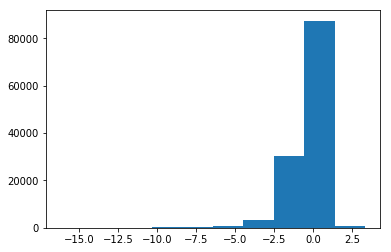

In [27]:
plt.hist(y_predict)

In [28]:
submission = pd.DataFrame({'card_id':testindex, 'target':y_predict})
submission.to_csv('/root/tempfile/submission12231201.csv',index=False)